- Load necessary module

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multinomial
from collections import OrderedDict

- Load model that defined in channel realization

In [2]:
mat = io.loadmat('temp.mat')
model = {}
model['H'] = mat['H']
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
model['Ns'] = 1 ## need to change nb of stream in channel realization, this case 1
model['Nt'] = mat['Nt'][0,0]
model['Nr'] = mat['Nr'][0,0]
model['Nc'] = mat['Nc'][0,0]
model['Nray'] = mat['Nray'][0,0]
model['realization'] = mat['realization'][0,0]
model['At'] = mat['At']
model['Ar'] = mat['Ar']
model['Nrf'] = 2

In [3]:
for key in model:
    print(key)

Nt
Nrf
Nc
realization
Nr
H
At
Fopt
Ns
Ar
Wopt
Nray


Load values of phase shifter included:
- nb_bit: number of bit
- nb_ps: number of phase shifter in the system
- nb_state: number of state in each phase shifter (2^nb_bit)

### Helper function for Cross entropy Beamforming

In [4]:
def phase_shifter(N):
    """
    Define phase shifter with N bits resolution
    
    Arguments:
    N -- number of bits resolutions
    
    Returns:
    y -- python dictionnary of phase shifter: index of state and value of phase
    """
    nb_state = 2**N
    w = np.exp(1j*2*np.pi/nb_state)
    ps = np.zeros(nb_state,dtype=complex)
    for i in range(nb_state):
        ps[i] = w**i
    return np.around(ps, decimals=2)

def generate_candidat(S,model,phase_value,ps_system_proba):
    """
    generate S candidates from the previous pmf
    
    Arguments: 
    S -- Number of candidates to generate
    model -- channel model
    phase_value -- possible phase shifted value
    ps_system_proba -- pmf of phase shifters
    
    Returns
    F_rf -- S analog precoder system
    """
    F_rf = np.zeros((S,model['Nt'],model['Nrf']),dtype=complex)
    for i in range(S):
        for j in range(model['Nt']):
            for k in range(model['Nrf']):
                F_rf[i,j,k] = np.random.choice(phase_value, 1, p=ps_system_proba[j,k,:])
    return F_rf

def compute_Fbb(F_rf,model):
    """
    Compute baseband precoder base on the effective channel (Heq = H*Frf)
    
    Arguments:
    F_rf -- analog precoder
    model -- channel model
    
    Returns:
    F_bb -- S baseband precoder
    """
    S = F_rf.shape[0]
    channel_eq = np.zeros((S,model['Nr'],model['Nrf']),dtype=complex)
    F_bb = np.zeros((S,model['Nrf'],model['Ns']),dtype=complex)
    channel_index = 0 ### need to adjust 
    for i in range(S):
        channel_eq[i,:,:] =  model['H'][:,:,channel_index]@F_rf[i,:,:]
        U, s, V = np.linalg.svd(channel_eq[i,:,:], full_matrices=True)
        V = V.conj().T
        F_bb[i,:,:] = V[0:model['Nt'],0:model['Ns']]
    return F_bb

def optimal_combiner(model, channel_index):
    """
    Compute the optimal combiner by SVD
    
    Arguments:
    model -- channel model
    channel_index -- index in 1000 realization channel
    
    Returns:
    Wopt -- optimal combiner
    """
    Wopt = np.zeros((model['Nr'],model['Ns']),dtype=complex)
    U, s, V = np.linalg.svd(model['H'][:,:,channel_index], full_matrices=True)
    V = V.conj().T
    # Fopt[:,:,reali] = V[0:Nt,0:Ns]
    Wopt = U[0:model['Nr'],0:model['Ns']]
    return Wopt

def update_pmf(F_elites,phase_value,nb_elite):
    """
    Update new phase shifters's pmf base on previous candidates's results
    
    Arguments:
    F_elites -- elites analog precoder
    phase_value -- phase shift value
    nb_elite -- number of elites 
    """
    alpha = 0.9
    nb_state = phase_value.shape[0]
    stat_count = np.zeros(nb_state)
    for i in range(model['Nt']):
        for j in range(model['Nrf']):
            unique, counts = np.unique(F_elites[:,i,j], return_counts=True)
            value_count = dict(zip(unique, counts))
            for k in range(nb_state):
                if phase_value[k] in value_count:   
                    proba_est = value_count[phase_value[k]]/nb_elite
                else:
                    proba_est = 0
                ps_system_proba[i,j,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,j,k] 
    return ps_system_proba

### Define Phase shiter

In [5]:
nb_bit = 6
nb_ps = model['Nt']*model['Nrf']
nb_ps
nb_state = 2**nb_bit

In [6]:
phase_value = phase_shifter(nb_bit)
phase_value

array([ 1.  +0.  j,  1.  +0.1 j,  0.98+0.2 j,  0.96+0.29j,  0.92+0.38j,
        0.88+0.47j,  0.83+0.56j,  0.77+0.63j,  0.71+0.71j,  0.63+0.77j,
        0.56+0.83j,  0.47+0.88j,  0.38+0.92j,  0.29+0.96j,  0.2 +0.98j,
        0.1 +1.  j,  0.  +1.  j, -0.1 +1.  j, -0.2 +0.98j, -0.29+0.96j,
       -0.38+0.92j, -0.47+0.88j, -0.56+0.83j, -0.63+0.77j, -0.71+0.71j,
       -0.77+0.63j, -0.83+0.56j, -0.88+0.47j, -0.92+0.38j, -0.96+0.29j,
       -0.98+0.2 j, -1.  +0.1 j, -1.  +0.  j, -1.  -0.1 j, -0.98-0.2 j,
       -0.96-0.29j, -0.92-0.38j, -0.88-0.47j, -0.83-0.56j, -0.77-0.63j,
       -0.71-0.71j, -0.63-0.77j, -0.56-0.83j, -0.47-0.88j, -0.38-0.92j,
       -0.29-0.96j, -0.2 -0.98j, -0.1 -1.  j, -0.  -1.  j,  0.1 -1.  j,
        0.2 -0.98j,  0.29-0.96j,  0.38-0.92j,  0.47-0.88j,  0.56-0.83j,
        0.63-0.77j,  0.71-0.71j,  0.77-0.63j,  0.83-0.56j,  0.88-0.47j,
        0.92-0.38j,  0.96-0.29j,  0.98-0.2 j,  1.  -0.1 j])

Phase shifter system dimension is: NtxNrfxN_state

### Cross entropy beamforming Algorithm
 Step 1: Randomly generate S candidate analog beamformers

 Step 2: Compute S corresponding digital precoders Fbb based on the effective channel Heq = HFrf

 Step 3: Calculate the achievable sum-rate

 Step 4: Sort R in a descend order

 Step 5: Select elites as Frf_1, Frf_2, ..., Frf_elite

 Step 6: Update new pmf for each phase shifter

In [12]:
nb_elite = 40
S = 200
channel_index = 0
Wopt = optimal_combiner(model,channel_index)
nb_iterate = 30
ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
# R_max = np.zeros((nb_iterate))
proba_evo = np.copy(ps_system_proba[0,0,:])
print(proba_evo)
i = 0
relative_std = 1000 # initialize high value of relative standard deviation

while ((i<nb_iterate) and (relative_std>3)):
    print(i)
    F_rf = generate_candidat(S,model,phase_value,ps_system_proba)
    F_bb = compute_Fbb(F_rf,model)
    SNR = 10**(10/10)
    R = np.zeros((S))
    for j in range(S):
        R[j] = np.log2(np.linalg.det(np.eye(model['Ns']))+SNR/model['Ns']*np.linalg.pinv(Wopt)@model['H'][:,:,channel_index]@F_rf[j,:,:]@F_bb[j,:,:]@F_bb[j,:,:].conj().T@F_rf[j,:,:].conj().T@model['H'][:,:,channel_index].conj().T@Wopt).real
    R_sort_index = np.argsort(R)[::-1][:nb_elite]
    if i==0:
        R_max = R[R_sort_index[0]]
    else:
        R_max = np.append(R_max,R[R_sort_index[0]])
    F_elites = F_rf[R_sort_index,:,:]
    Frf_max = F_rf[R_sort_index[0],:,:]
    Fbb_max = F_bb[R_sort_index[0],:,:]
    ps_system_proba = update_pmf(F_elites,phase_value,nb_elite)
    proba_evo = np.vstack((proba_evo,ps_system_proba[0,0,:]))
    if i>=5:
        R_max_normalize = R_max-np.min(R_max) ## Need to review
        relative_std = 100*np.std(R_max_normalize[i-5:i])/np.mean(R_max_normalize[i-5:i])
        print(relative_std)
    i +=1
    

[0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625]
0
1
2
3
4
5
105.47652686454111
6
80.49162886771603
7
53.68991397582331
8
44.38581902496686
9
23.916754546214772
10
21.31553198443171
11
15.546960366561764
12
10.127053487308153
13
9.094430580833167
14
7.893733289534999
15
7.444685328930028
16
5.118698377589195
17
3.111795509715388
18
2.6779062686635333


In [8]:
R_max.shape

(19,)

In [9]:
# Evolution of pmf of 1 phase shifter
np.around(proba_evo, decimals=2)

array([[0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.  , 0.  , 0.02, ..., 0.02, 0.  , 0.02],
       [0.  , 0.02, 0.05, ..., 0.02, 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.03, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.05, 0.  , 0.  ]])

In [10]:
proba_evo.shape

(20, 64)

[14.20994331 14.12216197 14.55360224 14.4451832  15.35670418 15.5407253
 15.82803142 16.2732499  16.47438437 16.75326006 16.81708801 16.99719396
 17.21737432 17.35396968 17.42678541 17.42162303 17.52499624 17.60951119
 17.64536371]


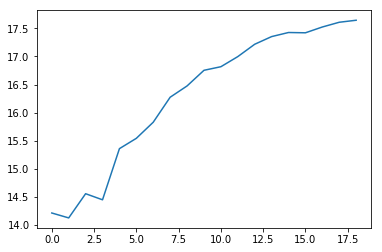

In [13]:
print(R_max)
plt.plot(R_max)

Test:

2 bits -- 17.56 bps/Hz - 16 iterate

3 bits -- 17.68 bps/Hz - 18 iterate

4 bits -- 17.71 bps/Hz - 18 iterate

6 bits -- 17.68 bps/Hz - 19 iterate